<a href="https://colab.research.google.com/github/Yaakov-Sternberg/AAI-500-Stats-Project/blob/main/Save_Final_Version_of_USD_Term_Project%2C_Computer_Vision%2C_Histopathological_Images%2C_Version_3_8_(Final_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To do:
* Check for data-leakage or any other reason the results seem to be be so high
* To consider adding:
 * **More Pre-trained Models** (ex. ResNet50, InceptionV3, EfficientNet)
 * **Optimize Hyperparameter Tuning** (learning rates, batch sizes, and optimizer settings)
 * **Data Augmentation** (more sophisticated augmentation techniques to improve generalization)
 * **K-fold Cross-Validation** (more robust validation, but resource heavy)
 * **Ensemble Methods** (combine models)
 * **Grad-CAM** (CNN analysis)

# Loading libraries & Data

In [12]:
# Standard libraries
import os
import random
import hashlib
import datetime
import json
import re
from dataclasses import dataclass
from itertools import cycle
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

# Data processing & analysis
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, UnidentifiedImageError
import cv2
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array
)

# Deep Learning - TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input
)

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

# Google Colab specific
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading Dataset from Kaggle

In [ ]:
# Install Kaggle API
!pip install kaggle

# Import libraries for file upload
from google.colab import files

# Upload kaggle.json file
files.upload()

# Create the Kaggle directory and copy the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

# Unzip dataset quietly (suppress output)
!unzip -q lung-and-colon-cancer-histopathological-images.zip -d data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
... resuming from 944766976 bytes (944597957 bytes left) ...
100% 1.75G/1.76G [00:11<00:00, 124MB/s]
100% 1.76G/1.76G [00:11<00:00, 79.6MB/s]


# **EDA & Pre-Processing**

EDA

In [ ]:
data_dir = Path('data/lung_colon_image_set')
subdirs = ['lung_image_sets', 'colon_image_sets']

def get_classes(data_dir, subdirs):
    """Retrieve class paths from specified subdirectories."""
    class_paths = {}
    for subdir in subdirs:
        subdir_path = data_dir / subdir
        for cls in subdir_path.iterdir():
            if cls.is_dir():
                class_paths.setdefault(cls.name, []).append(cls)
    return class_paths

def display_sample_images(class_paths, images_per_class=5):
    """Display a sample of images from each class."""
    num_classes = len(class_paths)

    # Adjust figure size based on number of classes
    fig_height = num_classes * 3 if num_classes > 0 else 5
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(15, fig_height))

    # Ensure axes is a 2D array
    if num_classes == 1:
        axes = [axes]

    for idx, (cls, paths) in enumerate(class_paths.items()):
        images = []
        for path in paths:
            images.extend(list(path.iterdir()))
        selected_images = random.sample(images, images_per_class)
        for i, img_path in enumerate(selected_images):
            with Image.open(img_path) as img:
                axes[idx, i].imshow(img)
            axes[idx, i].set_title(cls)
            axes[idx, i].axis('off')

    plt.tight_layout()
    plt.show()

def find_and_remove_duplicates(class_paths):
    """Find and remove duplicate images based on MD5 hash."""
    hash_dict = {}
    duplicates = []

    for cls, paths in class_paths.items():
        for path in paths:
            for img_path in path.iterdir():
                if img_path.is_file():
                    with open(img_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hash_dict:
                        duplicates.append(img_path)
                    else:
                        hash_dict[file_hash] = img_path

    total_duplicates = len(duplicates)
    print(f"\nTotal duplicate images found: {total_duplicates}")

    # Remove duplicates (without printing each removal)
    if total_duplicates > 0:
        for dup in duplicates:
            dup.unlink()
        print(f"Removed {total_duplicates} duplicate image(s).")
    else:
        print("No duplicate images found.")

def main():
    # Retrieve class paths
    class_paths = get_classes(data_dir, subdirs)

    # Calculate class counts
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}

    print("Classes:", list(class_counts.keys()))
    print("Number of images per class:", class_counts)

    # Display sample images
    display_sample_images(class_paths, images_per_class=5)

    # Find and remove duplicate images
    find_and_remove_duplicates(class_paths)

    # Recalculate class counts after removing duplicates
    class_counts = {cls: sum(len(list(path.iterdir())) for path in paths) for cls, paths in class_paths.items()}
    print("\nUpdated number of images per class after removing duplicates:", class_counts)

if __name__ == "__main__":
    main()


Data Preparation

In [ ]:
# Creating a DataFrame of Image Paths and Labels
image_paths = []
labels = []

for subdir in ['lung_image_sets', 'colon_image_sets']:
    subdir_path = os.path.join(data_dir, subdir)
    for cls in os.listdir(subdir_path):
        cls_dir = os.path.join(subdir_path, cls)
        if not os.path.isdir(cls_dir):
            continue  # Skip if not a directory
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(cls)
            else:
                print(f"Missing or invalid file skipped: {img_path}")

# Create DataFrame
df = pd.DataFrame({'filename': image_paths, 'label': labels})
df.head()

print("Total samples:", len(df))
print("Missing filenames:", df['filename'].isnull().sum())
print("Missing labels:", df['label'].isnull().sum())

Total samples: 23720
Missing filenames: 0
Missing labels: 0


In [ ]:
# Encoding Labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print("Encoded labels:", list(label_encoder.classes_))


Encoded labels: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Data Splitting

In [ ]:
# Split the dataset into training (60%), validation (20%), and test (20%) sets

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_val_idx, test_idx in split.split(df, df['label_encoded']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

split_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1234)
for train_idx, val_idx in split_val.split(train_val_df, train_val_df['label_encoded']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]


print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

print("Training set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("Validation set class distribution:")
print(val_df['label'].value_counts(normalize=True))
print("Test set class distribution:")
print(test_df['label'].value_counts(normalize=True))

Training set size: 14232
Validation set size: 4744
Test set size: 4744
Training set class distribution:
label
colon_n      0.201237
colon_aca    0.200393
lung_n       0.199972
lung_aca     0.199269
lung_scc     0.199129
Name: proportion, dtype: float64
Validation set class distribution:
label
colon_n      0.201096
colon_aca    0.200253
lung_n       0.200042
lung_aca     0.199410
lung_scc     0.199199
Name: proportion, dtype: float64
Test set class distribution:
label
colon_n      0.201096
colon_aca    0.200464
lung_n       0.200042
lung_aca     0.199199
lung_scc     0.199199
Name: proportion, dtype: float64


# Modeling Methods

In [10]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '1234'
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

# Define image sizes and batch size
IMG_SIZES = {
    'cnn': (224, 224),        # For the CNN model (I'd like to see if increases improves training)
    'vgg16': (224, 224),       # For the VGG16 model
    'resnet50': (224, 224)       # For the resnet50 model
}
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 10
SAVE_PATH = '/content/drive/MyDrive/ml_models8'
SEED = 1234

# Ensure save directory exists
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
CLASSES = list(label_encoder.classes_)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Helper function to get preprocessing function based on model type
def get_preprocessing_function(model_type):
    if model_type == 'vgg16':
        return vgg_preprocess_input
    elif model_type == 'resnet50':
        return resnet_preprocess_input
    else:
        return None


# Function to create data generators
def create_generators(train_df, val_df, test_df, img_size, batch_size, model_type, seed=SEED):
    preprocessing_function = get_preprocessing_function(model_type)

    train_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.999, 1.001], # Minimal - Consider removing
        channel_shift_range=1 # Minimal - Consider removing
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255 if preprocessing_function is None else None,
        preprocessing_function=preprocessing_function
    )

    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )

    val_gen = test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    test_gen = test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='label',
        target_size=img_size,
        classes=CLASSES,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=False,
        seed=seed
    )

    return train_gen, val_gen, test_gen



# Model building functions

# Build CNN Model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build VGG16 Transfer Learning Model
def build_vgg16_model(input_shape, num_classes, trainable_layers=0):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially (To do: try comparing with no freeze or different freeze)

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build ResNet50 Transfer Learning Model
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially (To do: try comparing with no freeze or different freeze)

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Common callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
tensorboard_callback = TensorBoard(log_dir='./logs')



# Training helper function
def train_and_evaluate_model(model, train_gen, val_gen, test_gen, model_name):
    checkpoint_filepath = f'{model_name}_model_{timestamp}.keras'
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    # Train model
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        validation_data=val_gen,
        callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard_callback],
        verbose=1
    )

    # Load best model
    best_model = load_model(checkpoint_filepath)

    # Evaluate on test data
    test_metrics = best_model.evaluate(test_gen, verbose=1)
    metric_names = best_model.metrics_names
    print(f"\n{model_name.upper()} Test Metrics:")
    for name, value in zip(metric_names, test_metrics):
        print(f"{name}: {value}")

    # Save final model and history
    final_model_path = f'final_{model_name}_model_{timestamp}.keras'
    best_model.save(final_model_path)

    # Save model & history to drive
    best_model.save(f'{SAVE_PATH}/{model_name}_model.keras') # (Note: I initially forgot to add 'best_', so current saved results are not best)
    with open(f'{SAVE_PATH}/{model_name}_history.json', 'w') as f:
        json.dump(history.history, f)

    return best_model, history


# Create generators for each model type
model_types = ['cnn', 'vgg16', 'resnet50']
generators = {}
for m_type in model_types:
    train_gen, val_gen, test_gen = create_generators(train_df, val_df, test_df, IMG_SIZES[m_type], BATCH_SIZE, m_type)
    generators[m_type] = (train_gen, val_gen, test_gen)




def fine_tune_model(best_model_vgg16, generators, timestamp):
    # Fine-tune VGG16 model
    print("\nFine-tuning VGG16 model...")
    # Unfreeze top layers of base model
    base_model_vgg16 = best_model_vgg16.layers[0]  # Get base model
    base_model_vgg16.trainable = True
    # Freeze layers except last convolutional block (To do: try comparing with no freeze or different freeze)
    for layer in base_model_vgg16.layers[:-4]:
        layer.trainable = False
    # Recompile model with a lower learning rate
    best_model_vgg16.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    # Continue training (fine-tuning)
    history_vgg16_ft = best_model_vgg16.fit(
        generators['vgg16'][0],  # train_gen
        epochs=EPOCHS,
        validation_data=generators['vgg16'][1],  # val_gen
        callbacks=[early_stopping, ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1), tensorboard_callback],
        verbose=1
    )

    # Save fine-tuning history
    with open(f'{SAVE_PATH}/vgg16_finetuning_history.json', 'w') as f:
        json.dump(history_vgg16_ft.history, f)

    # Evaluate fine-tuned VGG16 on test data
    fine_tuned_model_vgg16 = best_model_vgg16  # already the fine-tuned model (previously used 'load_model(checkpoint_filepath_vgg16)')
    fine_tuned_test_metrics_vgg16 = fine_tuned_model_vgg16.evaluate(generators['vgg16'][2])  # test_gen
    print("\nFine-tuned VGG16 Test Metrics:")
    for name, value in zip(fine_tuned_model_vgg16.metrics_names, fine_tuned_test_metrics_vgg16):
        print(f"{name}: {value}")

    # Save final models
    fine_tuned_model_vgg16.save(f'fine_tuned_vgg16model{timestamp}.keras')
    fine_tuned_model_vgg16.save(f'{SAVE_PATH}/fine_tuned_vgg16_model.keras')

    return fine_tuned_model_vgg16, history_vgg16_ft


Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 14232 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.
Found 4744 validated image filenames belonging to 5 classes.


In [13]:
# Build Models:
model_cnn = build_cnn_model(IMG_SIZES['cnn'] + (3,), NUM_CLASSES)
model_cnn.summary()
model_vgg16 = build_vgg16_model(IMG_SIZES['vgg16'] + (3,), NUM_CLASSES)
model_vgg16.summary()
model_resnet50 = build_resnet50_model(IMG_SIZES['resnet50'] + (3,), NUM_CLASSES)
model_resnet50.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,014,245 (99.24 MB)

 Trainable params: 26,012,581 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,325 (56.64 MB)

 Trainable params: 133,125 (520.02 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,114,565 (91.99 MB)

 Trainable params: 526,341 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

CNN Attempt 8

In [ ]:
# Train CNN
best_model_cnn, history_cnn = train_and_evaluate_model(model_cnn, *generators['cnn'], 'cnn')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6228 - auc: 0.8838 - loss: 1.0351 - precision: 0.6475 - recall: 0.5821
Epoch 1: val_loss improved from inf to 1.89632, saving model to cnn_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 386s 754ms/step - accuracy: 0.6230 - auc: 0.8839 - loss: 1.0345 - precision: 0.6477 - recall: 0.5823 - val_accuracy: 0.4762 - val_auc: 0.7857 - val_loss: 1.8963 - val_precision: 0.5103 - val_recall: 0.4665 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8091 - auc: 0.9665 - loss: 0.5015 - precision: 0.8209 - recall: 0.7939
Epoch 2: val_loss improved from 1.89632 to 1.05307, saving model to cnn_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 298s 645ms/step - accuracy: 0.8091 - auc: 0.9665 - loss: 0.5014 - precision: 0.8210 - recall: 0.7940 - val_accuracy: 0.7348 - val_auc: 0.9203 - val_loss: 1.0531 - val_precision: 0.7354 - val_recall: 0.7329 - learning_rate: 1.0000e-04
Epoch 3/10


CNN attempt 9 see "VGG16 Attempt 9" for changes made from attempt 8

CNN performed slightly worse than before.

In [ ]:
# Train CNN
best_model_cnn, history_cnn = train_and_evaluate_model(model_cnn, *generators['cnn'], 'cnn')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6835 - auc: 0.9118 - loss: 0.8702 - precision: 0.7052 - recall: 0.6507
Epoch 1: val_loss improved from inf to 4.42049, saving model to cnn_model_20241211-061807.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 241s 511ms/step - accuracy: 0.6837 - auc: 0.9119 - loss: 0.8696 - precision: 0.7053 - recall: 0.6509 - val_accuracy: 0.2639 - val_auc: 0.5994 - val_loss: 4.4205 - val_precision: 0.2642 - val_recall: 0.2553 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.8501 - auc: 0.9762 - loss: 0.4069 - precision: 0.8579 - recall: 0.8425
Epoch 2: val_loss improved from 4.42049 to 1.28479, saving model to cnn_model_20241211-061807.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 223s 493ms/step - accuracy: 0.8501 - auc: 0.9762 - loss: 0.4068 - precision: 0.8579 - recall: 0.8426 - val_accuracy: 0.7169 - val_auc: 0.9205 - val_loss: 1.2848 - val_precision: 0.7172 - val_recall: 0.7156 - learning_rate: 1.0000e-04
Epoch 3/10


CNN attempt 10 (don't think I made any changes

In [ ]:
# Train CNN
best_model_cnn, history_cnn = train_and_evaluate_model(model_cnn, *generators['cnn'], 'cnn')

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6859 - auc: 0.9168 - loss: 0.8441 - precision: 0.7064 - recall: 0.6546
Epoch 1: val_loss improved from inf to 2.56357, saving model to cnn_model_20241211-075259.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 242s 512ms/step - accuracy: 0.6861 - auc: 0.9169 - loss: 0.8437 - precision: 0.7066 - recall: 0.6548 - val_accuracy: 0.4342 - val_auc: 0.6999 - val_loss: 2.5636 - val_precision: 0.4577 - val_recall: 0.4188 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8410 - auc: 0.9751 - loss: 0.4215 - precision: 0.8490 - recall: 0.8302
Epoch 2: val_loss improved from 2.56357 to 1.89893, saving model to cnn_model_20241211-075259.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 221s 490ms/step - accuracy: 0.8410 - auc: 0.9751 - loss: 0.4215 - precision: 0.8490 - recall: 0.8303 - val_accuracy: 0.6663 - val_auc: 0.8576 - val_loss: 1.8989 - val_precision: 0.6680 - val_recall: 0.6642 - learning_rate: 1.0000e-04


VGG16 Atempt 8

In [ ]:
# Train VGG16
best_model_vgg16, history_vgg16 = train_and_evaluate_model(model_vgg16, *generators['vgg16'], 'vgg16')
fine_tuned_model_vgg16, history_vgg16_ft = fine_tune_model(best_model_vgg16, generators, timestamp)

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.5924 - auc: 0.8466 - loss: 1.1569 - precision: 0.6351 - recall: 0.5316
Epoch 1: val_loss improved from inf to 0.23843, saving model to vgg16_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 340s 711ms/step - accuracy: 0.5927 - auc: 0.8468 - loss: 1.1559 - precision: 0.6355 - recall: 0.5320 - val_accuracy: 0.9136 - val_auc: 0.9915 - val_loss: 0.2384 - val_precision: 0.9214 - val_recall: 0.9045 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.8901 - auc: 0.9874 - loss: 0.2981 - precision: 0.9053 - recall: 0.8744
Epoch 2: val_loss improved from 0.23843 to 0.22128, saving model to vgg16_model_20241209-201324.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 300s 666ms/step - accuracy: 0.8901 - auc: 0.9874 - loss: 0.2981 - precision: 0.9053 - recall: 0.8744 - val_accuracy: 0.9222 - val_auc: 0.9915 - val_loss: 0.2213 - val_precision: 0.9283 - val_recall: 0.9169 - learning_rate: 1.0000e

VGG16 Attempt 9:

I noticed VGG was doing much better in "Histopathological Images Project, Version 2" (particularly in testing phase, where here val results were surprisingly lower then test results), so I made some changes to go back to make things more similar to that version. Specifically:
* Removed class weights since the dataset is balanced

* Reduced 'brightness_range' from [.8, 1.2] to [0.999, 1.001]
* Reduced 'channel_shift_range' from 5 to 1.
* Reduced 'reduce_lr' factor from 0.5 to 0.3

Version 2 didn't have these at all, so if these results are still inferior to versions, we should probably do that.

---

Version 2 had the following results after 5 epochs:

Original version 2, epoch 5:
* 469/469 ━ 207s 435ms/step
* AUC: 0.9939 - Precision: 0.9348 - Recall: 0.9201 - accuracy: 0.9271 - loss: 0.2031 - val_AUC: 0.9975
* val_Precision: 0.9543 - val_Recall: 0.9488 - val_accuracy: 0.9522 - val_loss: 0.1319 - learning_rate: 1.0000e-04

Version 2 with duplicate removed, epoch 5:
* 469/469 ━ 254s 536ms/step
* AUC: 0.9938 - Precision: 0.9359 - Recall: 0.9187 - accuracy: 0.9279 - loss: 0.2071
* val_AUC: 0.9985 - val_Precision: 0.9646 - val_Recall: 0.9584 - val_accuracy: 0.9626 - val_loss: 0.1039 - learning_rate: 1.0000e-04


In [ ]:
# Train VGG16
best_model_vgg16, history_vgg16 = train_and_evaluate_model(model_vgg16, *generators['vgg16'], 'vgg16')
fine_tuned_model_vgg16, history_vgg16_ft = fine_tune_model(best_model_vgg16, generators, timestamp)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.6109 - auc: 0.8538 - loss: 1.1270 - precision: 0.6586 - recall: 0.5484
Epoch 1: val_loss improved from inf to 0.22053, saving model to vgg16_model_20241210-101420.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 239s 522ms/step - accuracy: 0.6113 - auc: 0.8540 - loss: 1.1260 - precision: 0.6590 - recall: 0.5487 - val_accuracy: 0.9197 - val_auc: 0.9931 - val_loss: 0.2205 - val_precision: 0.9293 - val_recall: 0.9087 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8900 - auc: 0.9861 - loss: 0.3085 - precision: 0.9024 - recall: 0.8748
Epoch 2: val_loss improved from 0.22053 to 0.18439, saving model to vgg16_model_20241210-101420.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 234s 518ms/step - accuracy: 0.8900 - auc: 0.9861 - loss: 0.3084 - precision: 0.9024 - recall: 0.8748 - val_accuracy: 0.9325 - val_auc: 0.9946 - val_loss: 0.1844 - val_precision: 0.9392 - val_recall: 0.9275 - learning_rate: 1.0000e-04
Epoch 3

ResNet50

ResNet50 atempt 1

In [ ]:
# Train ResNet50
best_model_resnet50, history_resnet50 = train_and_evaluate_model(model_resnet50, *generators['cnn'], 'resnet50')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.5104 - auc: 0.8189 - loss: 1.1730 - precision: 0.6104 - recall: 0.3242
Epoch 1: val_loss improved from inf to 0.94925, saving model to resnet50_model_20241210-043936.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 256s 538ms/step - accuracy: 0.5105 - auc: 0.8190 - loss: 1.1727 - precision: 0.6106 - recall: 0.3244 - val_accuracy: 0.7121 - val_auc: 0.9267 - val_loss: 0.9493 - val_precision: 0.8875 - val_recall: 0.2028 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6814 - auc: 0.9214 - loss: 0.7852 - precision: 0.7413 - recall: 0.5725
Epoch 2: val_loss did not improve from 0.94925
445/445 ━━━━━━━━━━━━━━━━━━━━ 228s 504ms/step - accuracy: 0.6814 - auc: 0.9214 - loss: 0.7852 - precision: 0.7413 - recall: 0.5726 - val_accuracy: 0.5377 - val_auc: 0.8143 - val_loss: 1.6656 - val_precision: 0.5512 - val_recall: 0.5160 - learning_rate: 1.0000e-04
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - acc

ResNet50 atempt 2

In [ ]:
# Train ResNet50
best_model_resnet50, history_resnet50 = train_and_evaluate_model(model_resnet50, *generators['cnn'], 'resnet50')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.5165 - auc: 0.8236 - loss: 1.1584 - precision: 0.6354 - recall: 0.3110
Epoch 1: val_loss improved from inf to 1.23580, saving model to resnet50_model_20241210-083221.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 247s 517ms/step - accuracy: 0.5167 - auc: 0.8238 - loss: 1.1580 - precision: 0.6355 - recall: 0.3112 - val_accuracy: 0.5337 - val_auc: 0.7956 - val_loss: 1.2358 - val_precision: 0.6647 - val_recall: 0.4313 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6777 - auc: 0.9200 - loss: 0.7954 - precision: 0.7456 - recall: 0.5561
Epoch 2: val_loss improved from 1.23580 to 1.12047, saving model to resnet50_model_20241210-083221.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 223s 494ms/step - accuracy: 0.6778 - auc: 0.9200 - loss: 0.7954 - precision: 0.7456 - recall: 0.5562 - val_accuracy: 0.5991 - val_auc: 0.8742 - val_loss: 1.1205 - val_precision: 0.6242 - val_recall: 0.5774 - learning_rate: 1.0000e-04
E

ResNet attempt 3 see "VGG16 Attempt 9" for changes made from previous

In [ ]:
# Train ResNet50
best_model_resnet50, history_resnet50 = train_and_evaluate_model(model_resnet50, *generators['cnn'], 'resnet50')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5432 - auc: 0.8353 - loss: 1.1263 - precision: 0.6442 - recall: 0.3424
Epoch 1: val_loss improved from inf to 1.29670, saving model to resnet50_model_20241211-045254.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 247s 519ms/step - accuracy: 0.5434 - auc: 0.8354 - loss: 1.1259 - precision: 0.6444 - recall: 0.3426 - val_accuracy: 0.3472 - val_auc: 0.7733 - val_loss: 1.2967 - val_precision: 0.4824 - val_recall: 0.2770 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7238 - auc: 0.9342 - loss: 0.7231 - precision: 0.7778 - recall: 0.6276
Epoch 2: val_loss improved from 1.29670 to 0.62276, saving model to resnet50_model_20241211-045254.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 224s 496ms/step - accuracy: 0.7238 - auc: 0.9342 - loss: 0.7230 - precision: 0.7778 - recall: 0.6276 - val_accuracy: 0.7306 - val_auc: 0.9473 - val_loss: 0.6228 - val_precision: 0.7634 - val_recall: 0.6910 - learning_rate: 1.0000e-04
E

Resnet 50 attempt 4 (don't think any changes were made from attempt 3)

In [ ]:
# Build and train ResNet50
best_model_resnet50, history_resnet50 = train_and_evaluate_model(model_resnet50, *generators['resnet50'], 'resnet50')

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.4836 - auc: 0.7879 - loss: 1.2553 - precision: 0.6009 - recall: 0.3012
Epoch 1: val_loss improved from inf to 0.99902, saving model to resnet50_model_20241211-061807.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 235s 497ms/step - accuracy: 0.4839 - auc: 0.7880 - loss: 1.2547 - precision: 0.6011 - recall: 0.3014 - val_accuracy: 0.6298 - val_auc: 0.8935 - val_loss: 0.9990 - val_precision: 0.8186 - val_recall: 0.3272 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6999 - auc: 0.9264 - loss: 0.7650 - precision: 0.7616 - recall: 0.5935
Epoch 2: val_loss did not improve from 0.99902
445/445 ━━━━━━━━━━━━━━━━━━━━ 220s 487ms/step - accuracy: 0.6999 - auc: 0.9264 - loss: 0.7649 - precision: 0.7616 - recall: 0.5935 - val_accuracy: 0.5974 - val_auc: 0.8824 - val_loss: 1.0663 - val_precision: 0.6455 - val_recall: 0.5666 - learning_rate: 1.0000e-04
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms

ResNet Atempt 5:
Added ResNet 50 generators (for some reason I had the CNN gens before, probably a copy-paste oversight).

In [ ]:
# Build and train ResNet50
best_model_resnet50, history_resnet50 = train_and_evaluate_model(model_resnet50, *generators['resnet50'], 'resnet50')

Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7984 - auc: 0.9474 - loss: 0.5893 - precision: 0.8222 - recall: 0.7698
Epoch 1: val_loss improved from inf to 0.08336, saving model to resnet50_model_20241211-205443.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 242s 513ms/step - accuracy: 0.7986 - auc: 0.9475 - loss: 0.5887 - precision: 0.8224 - recall: 0.7701 - val_accuracy: 0.9675 - val_auc: 0.9988 - val_loss: 0.0834 - val_precision: 0.9679 - val_recall: 0.9667 - learning_rate: 1.0000e-04
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9520 - auc: 0.9972 - loss: 0.1301 - precision: 0.9544 - recall: 0.9482
Epoch 2: val_loss improved from 0.08336 to 0.06165, saving model to resnet50_model_20241211-205443.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 228s 504ms/step - accuracy: 0.9520 - auc: 0.9972 - loss: 0.1301 - precision: 0.9544 - recall: 0.9482 - val_accuracy: 0.9770 - val_auc: 0.9995 - val_loss: 0.0616 - val_precision: 0.9776 - val_recall: 0.9760 - learning_rate: 1

# Load Model

In [ ]:
# Load models
loaded_cnn = load_model(f'{save_path}/cnn_model.keras')
loaded_vgg16 = load_model(f'{save_path}/vgg16_model.keras')
loaded_resnet50 = load_model(f'{save_path}/resnet50_model.keras')

# Load training histories
with open(f'{save_path}/cnn_history.json', 'r') as f:
    loaded_cnn_history = json.load(f)
with open(f'{save_path}/vgg16_history.json', 'r') as f:
    loaded_vgg16_history = json.load(f)
with open(f'{save_path}/vgg16_finetuning_history.json', 'r') as f:
    loaded_vgg16_ft_history = json.load(f)
with open(f'{save_path}/resnet50_history.json', 'r') as f:
    loaded_resnet50_history = json.load(f)
print("All loaded")

All loaded


# Validation & Performance Metrics

In [ ]:
# Evaluate CNN on Test Set
print("\n CNN Test Results:")
loss_cnn_test, accuracy_cnn_test, auc_cnn_test, precision_cnn_test, recall_cnn_test = loaded_cnn.evaluate(test_gen_cnn)
print(f"Test Accuracy: {accuracy_cnn_test*100:.2f}%")
print(f"Test AUC: {auc_cnn_test:.4f}")
print(f"Test Precision: {precision_cnn_test:.4f}")
print(f"Test Recall: {recall_cnn_test:.4f}")


# Evaluate VGG16 Fine-Tuned Model on Test Set
print("\nVGG16 Fine-Tuned Test Results:")
loss_vgg16_test, accuracy_vgg16_test, auc_vgg16_test, precision_vgg16_test, recall_vgg16_test = loaded_vgg16.evaluate(test_gen_vgg16)
print(f"Test Accuracy: {accuracy_vgg16_test*100:.2f}%")
print(f"Test AUC: {auc_vgg16_test:.4f}")
print(f"Test Precision: {precision_vgg16_test:.4f}")
print(f"Test Recall: {recall_vgg16_test:.4f}")

# Evaluate ResNet50 on the Test Set
print("\n ResNet50 Test Results:")
loss_resnet50_test, accuracy_resnet50_test, auc_resnet50_test, precision_resnet50_test, recall_resnet50_test = loaded_resnet50.evaluate(test_gen_resnet50)
print(f"Test Accuracy: {accuracy_resnet50_test*100:.2f}%")
print(f"Test AUC: {auc_resnet50_test:.4f}")
print(f"Test Precision: {precision_resnet50_test:.4f}")
print(f"Test Recall: {recall_resnet50_test:.4f}")


 CNN Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9502 - auc: 0.9955 - loss: 0.1436 - precision: 0.9512 - recall: 0.9498
Test Accuracy: 94.71%
Test AUC: 0.9949
Test Precision: 0.9477
Test Recall: 0.9469

VGG16 Fine-Tuned Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9720 - auc: 0.9991 - loss: 0.0771 - precision: 0.9738 - recall: 0.9699
Test Accuracy: 96.99%
Test AUC: 0.9989
Test Precision: 0.9721
Test Recall: 0.9682

 ResNet50 Test Results:
149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.9881 - auc: 0.9999 - loss: 0.0288 - precision: 0.9881 - recall: 0.9880
Test Accuracy: 98.82%
Test AUC: 0.9999
Test Precision: 0.9884
Test Recall: 0.9880


# Modeling Results & Findings:

* confusion matrices
* training history
* ROC curves

NOTE: This was not run on the most recent trainings and thus reflect older trainings

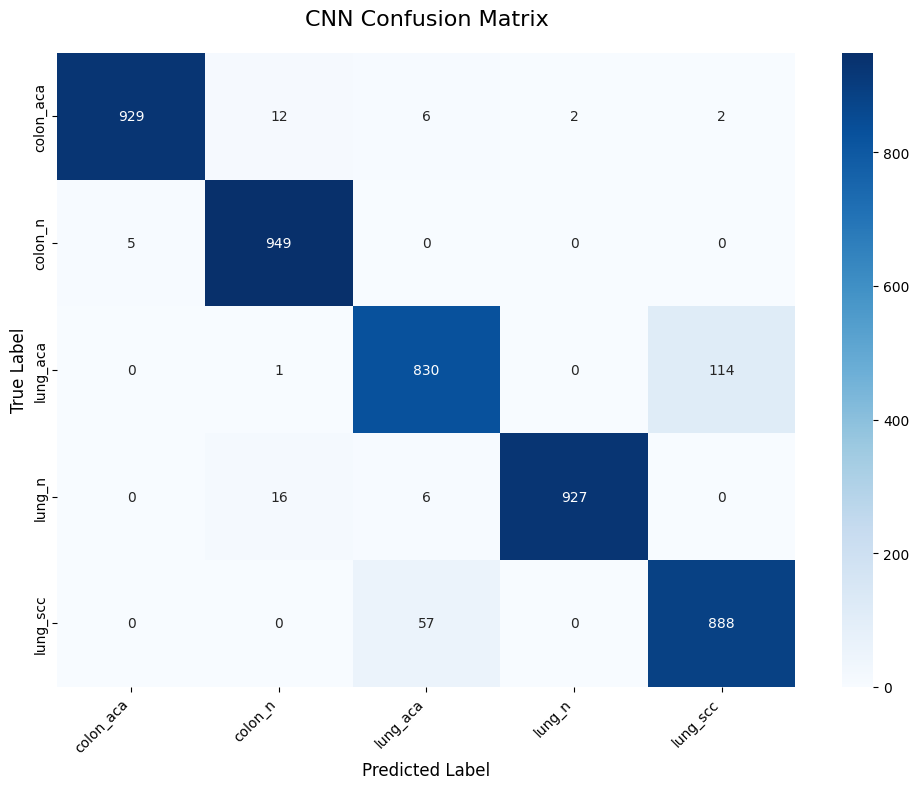


Classification Report for CNN Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99       951
     colon_n       0.97      0.99      0.98       954
    lung_aca       0.92      0.88      0.90       945
      lung_n       1.00      0.98      0.99       949
    lung_scc       0.88      0.94      0.91       945

    accuracy                           0.95      4744
   macro avg       0.95      0.95      0.95      4744
weighted avg       0.95      0.95      0.95      4744



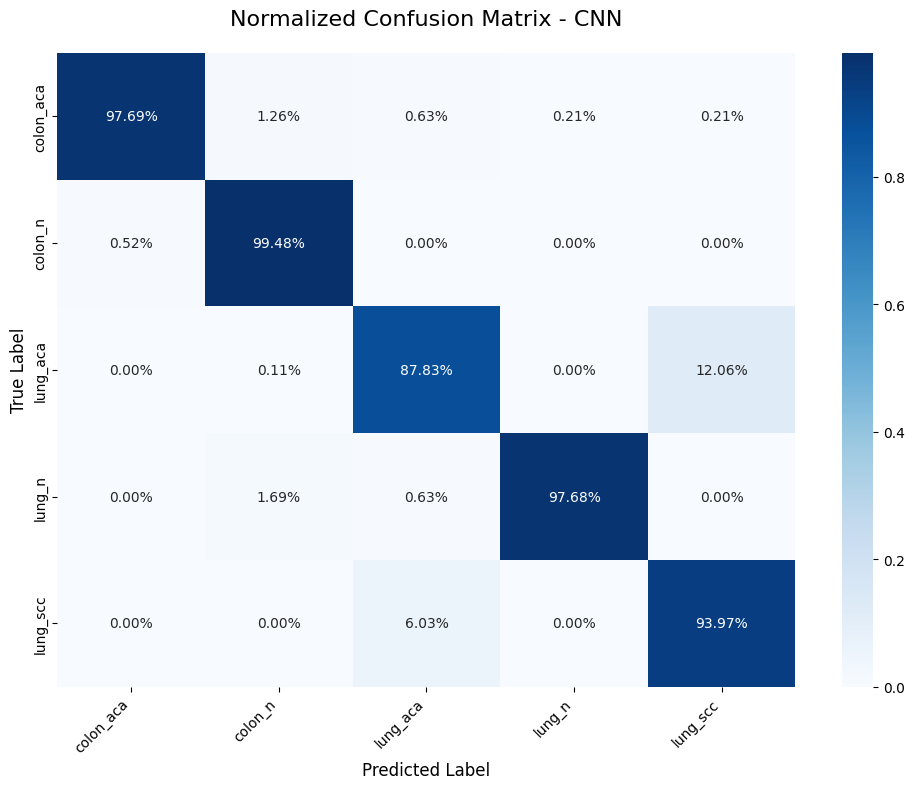


Classification Report for Normalized Confusion Matrix - CNN:
              precision    recall  f1-score   support

   colon_aca       0.99      0.98      0.99       951
     colon_n       0.97      0.99      0.98       954
    lung_aca       0.92      0.88      0.90       945
      lung_n       1.00      0.98      0.99       949
    lung_scc       0.88      0.94      0.91       945

    accuracy                           0.95      4744
   macro avg       0.95      0.95      0.95      4744
weighted avg       0.95      0.95      0.95      4744



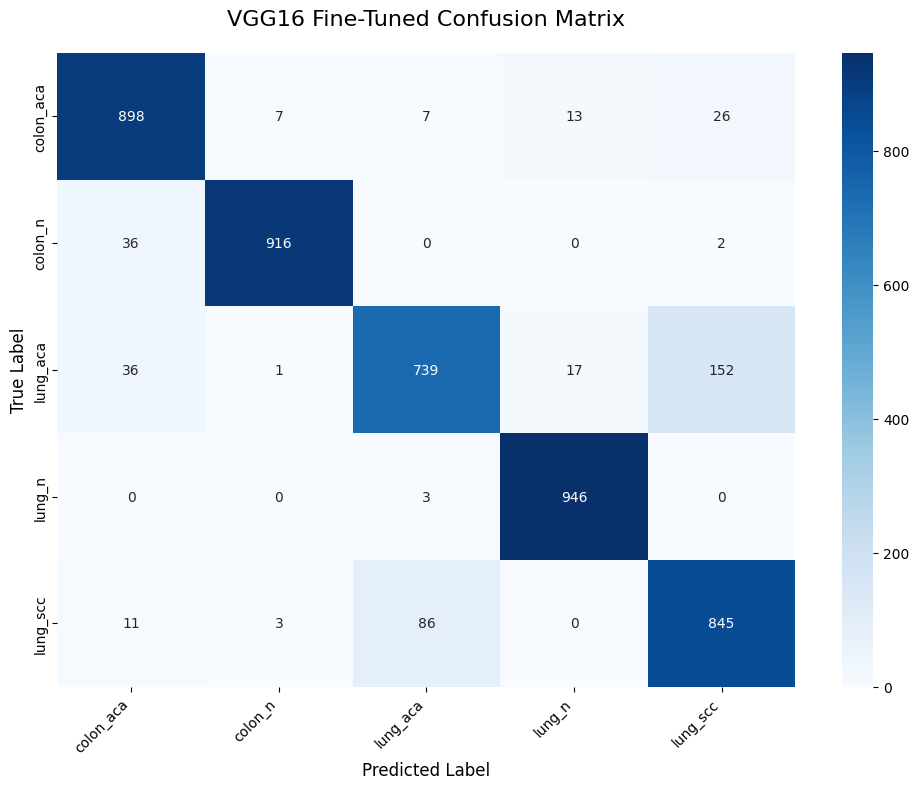


Classification Report for VGG16 Fine-Tuned Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.92      0.94      0.93       951
     colon_n       0.99      0.96      0.97       954
    lung_aca       0.89      0.78      0.83       945
      lung_n       0.97      1.00      0.98       949
    lung_scc       0.82      0.89      0.86       945

    accuracy                           0.92      4744
   macro avg       0.92      0.92      0.91      4744
weighted avg       0.92      0.92      0.92      4744



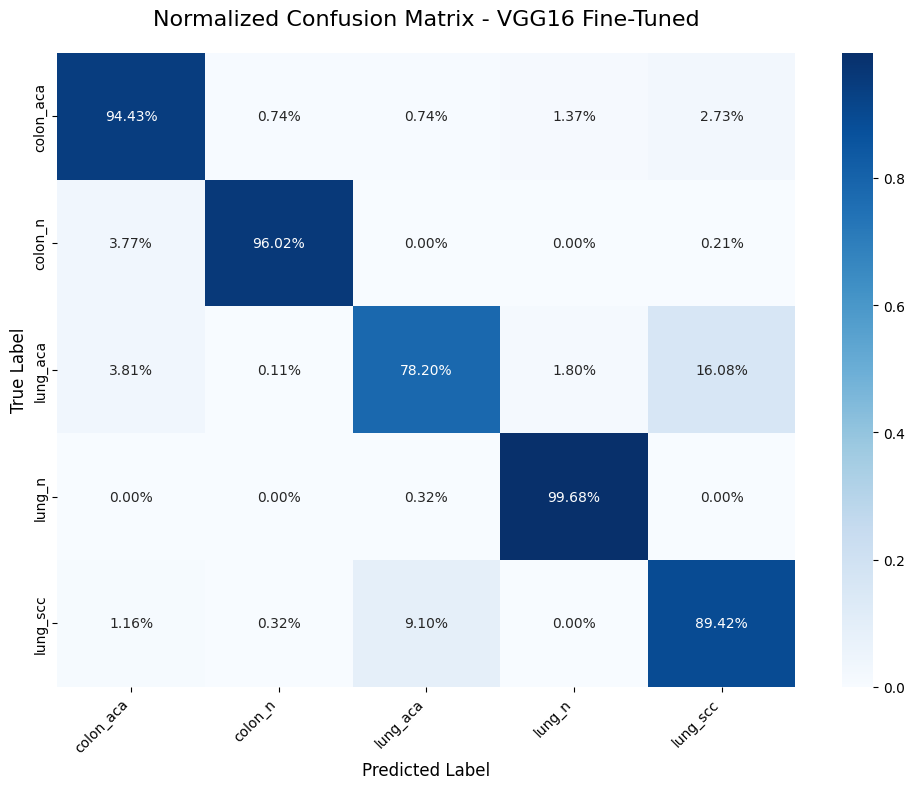


Classification Report for Normalized Confusion Matrix - VGG16 Fine-Tuned:
              precision    recall  f1-score   support

   colon_aca       0.92      0.94      0.93       951
     colon_n       0.99      0.96      0.97       954
    lung_aca       0.89      0.78      0.83       945
      lung_n       0.97      1.00      0.98       949
    lung_scc       0.82      0.89      0.86       945

    accuracy                           0.92      4744
   macro avg       0.92      0.92      0.91      4744
weighted avg       0.92      0.92      0.92      4744



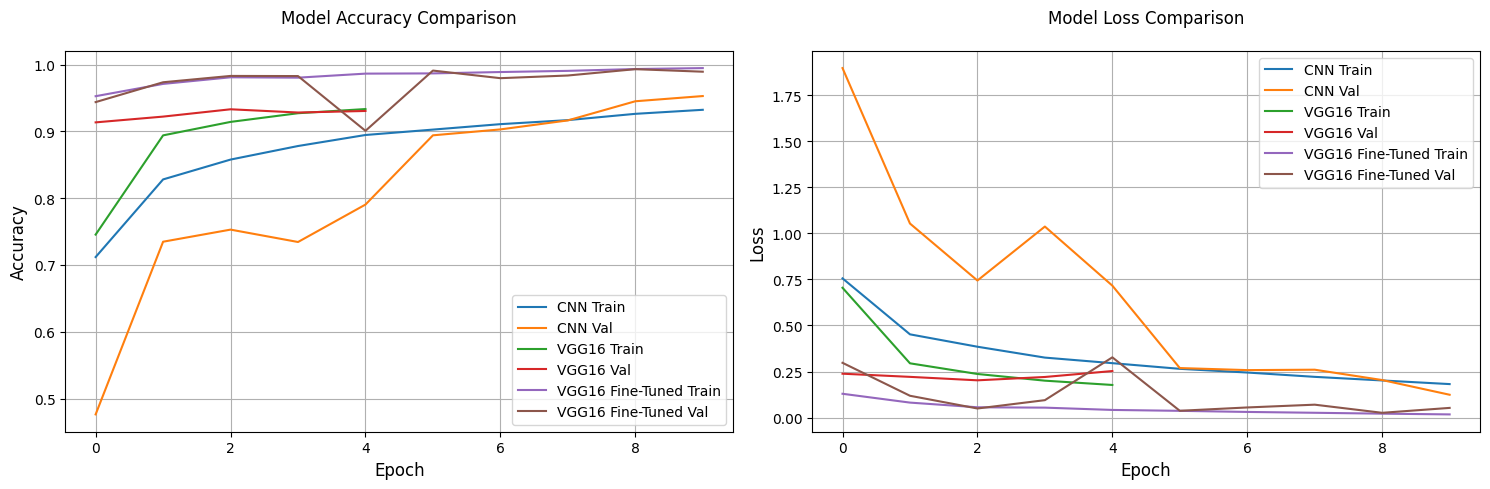

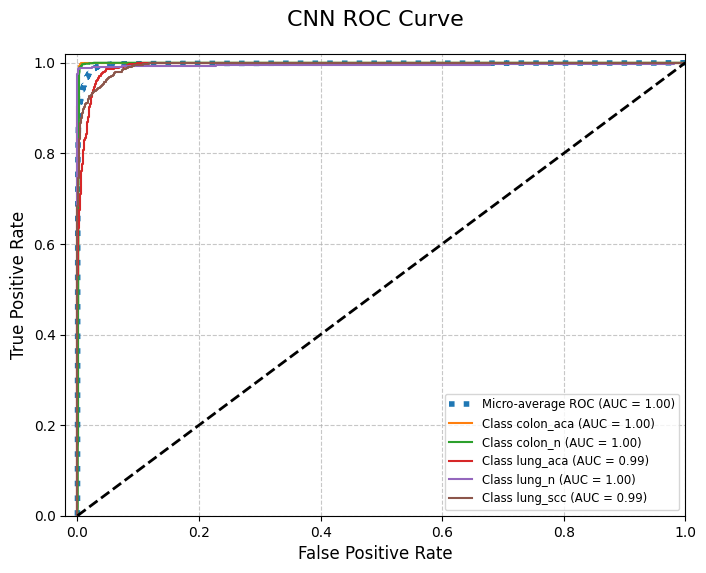

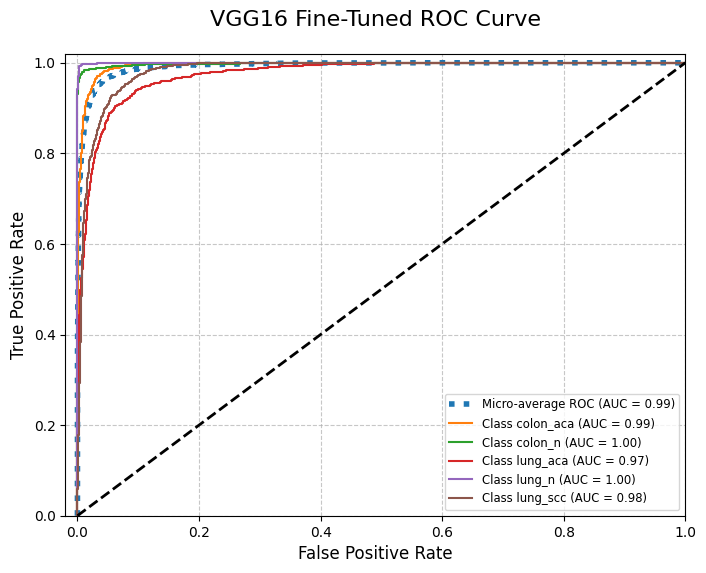

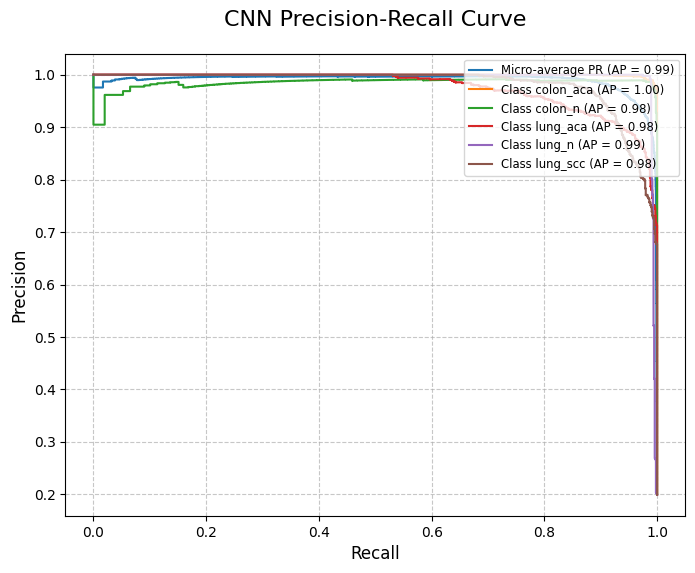

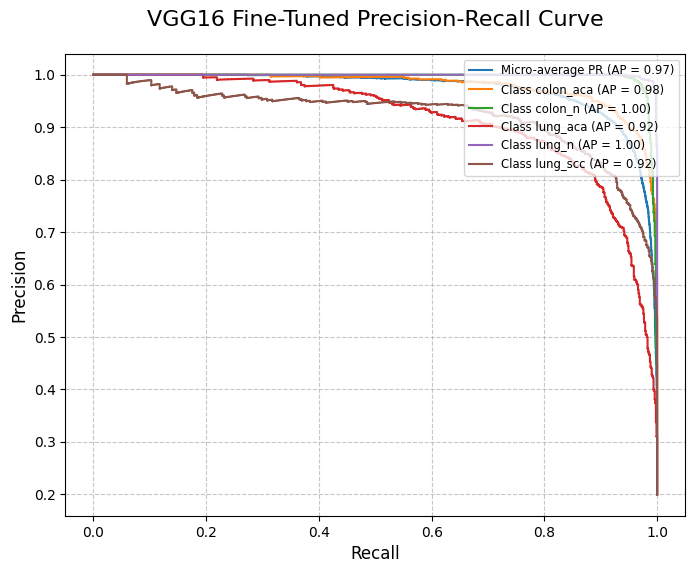

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve,
    auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

class ModelEvaluator:
    """
    A class for evaluating and visualizing machine learning model performance.
    """

    def __init__(self):
        """Initialize ModelEvaluator with default plot settings."""
        # Set default plotting parameters
        plt.rcParams['figure.figsize'] = (10, 8)
        plt.rcParams['axes.titlesize'] = 16
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10

        self.default_figsize = (10, 8)
        self.title_fontsize = 16
        self.label_fontsize = 12
        self.tick_fontsize = 10

    def plot_confusion_matrix(self, model, generator, title, normalize=False):
        """
        Plot the confusion matrix and print classification report.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            title (str): Title for the plot
            normalize (bool): Whether to normalize the confusion matrix
        """
        y_pred = model.predict(generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = generator.classes

        cm = confusion_matrix(y_true, y_pred_classes,
                            normalize='true' if normalize else None)

        plt.figure(figsize=self.default_figsize)
        fmt = '.2%' if normalize else 'd'
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=generator.class_indices.keys(),
                   yticklabels=generator.class_indices.keys())

        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.ylabel('True Label', fontsize=self.label_fontsize)
        plt.xlabel('Predicted Label', fontsize=self.label_fontsize)
        plt.xticks(rotation=45, ha='right', fontsize=self.tick_fontsize)
        plt.yticks(fontsize=self.tick_fontsize)
        plt.tight_layout()
        plt.show()

        print(f"\nClassification Report for {title}:")
        print(classification_report(y_true, y_pred_classes,
                                 target_names=generator.class_indices.keys()))

    def plot_training_history(self, histories, titles):
        """
        Compare training histories of multiple models.

        Args:
            histories (list): List of training history dictionaries
            titles (list): List of model titles corresponding to histories
        """
        metrics = ['accuracy', 'loss']
        subplot_titles = ['Model Accuracy Comparison', 'Model Loss Comparison']
        y_labels = ['Accuracy', 'Loss']
        legend_locations = ['lower right', 'upper right']

        plt.figure(figsize=(15, 5))

        for i, (metric, subplot_title, y_label, legend_loc) in enumerate(
            zip(metrics, subplot_titles, y_labels, legend_locations), 1
        ):
            plt.subplot(1, 2, i)
            for history, title in zip(histories, titles):
                plt.plot(history[f'{metric}'], label=f'{title} Train')
                plt.plot(history[f'val_{metric}'], label=f'{title} Val')

            plt.title(subplot_title, fontsize=self.label_fontsize, pad=20)
            plt.ylabel(y_label, fontsize=self.label_fontsize)
            plt.xlabel('Epoch', fontsize=self.label_fontsize)
            plt.legend(loc=legend_loc)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_multiclass_roc(self, model, generator, n_classes, title):
        """
        Plot ROC curves for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes (int): Number of classes
            title (str): Title for the plot
        """
        y_score = model.predict(generator, verbose=0)
        y_true = label_binarize(generator.classes, classes=range(n_classes))

        fpr, tpr, roc_auc = {}, {}, {}

        # Calculate ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                linestyle=':', linewidth=4)

        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                    label=f'Class {list(generator.class_indices.keys())[i]} '
                          f'(AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate', fontsize=self.label_fontsize)
        plt.ylabel('True Positive Rate', fontsize=self.label_fontsize)
        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_precision_recall_curve(self, model, generator, n_classes, title):
        """
        Plot Precision-Recall curve for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes (int): Number of classes
            title (str): Title for the plot
        """
        y_score = model.predict(generator, verbose=0)
        y_true = label_binarize(generator.classes, classes=range(n_classes))

        precision, recall, avg_precision = {}, {}, {}

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(
                y_true[:, i], y_score[:, i]
            )
            avg_precision[i] = average_precision_score(
                y_true[:, i], y_score[:, i]
            )

        # Compute micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_true.ravel(), y_score.ravel()
        )
        avg_precision["micro"] = average_precision_score(
            y_true, y_score, average="micro"
        )

        plt.figure(figsize=(8, 6))
        plt.step(recall['micro'], precision['micro'], where='post',
                label=f'Micro-average PR (AP = {avg_precision["micro"]:.2f})')

        for i in range(n_classes):
            plt.step(recall[i], precision[i], where='post',
                    label=f'Class {list(generator.class_indices.keys())[i]} '
                          f'(AP = {avg_precision[i]:.2f})')

        plt.xlabel('Recall', fontsize=self.label_fontsize)
        plt.ylabel('Precision', fontsize=self.label_fontsize)
        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def main():
    # Example usage
    evaluator = ModelEvaluator()

    # Evaluate CNN model
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn, 'CNN Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn,
                                  'Normalized Confusion Matrix - CNN',
                                  normalize=True)

    # Evaluate VGG16 model
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                  'VGG16 Fine-Tuned Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                  'Normalized Confusion Matrix - VGG16 Fine-Tuned',
                                  normalize=True)

    # Compare training histories
    histories = [loaded_cnn_history, loaded_vgg16_history, loaded_vgg16_ft_history]
    titles = ['CNN', 'VGG16', 'VGG16 Fine-Tuned']
    evaluator.plot_training_history(histories, titles)

    # Plot ROC and Precision-Recall curves
    n_classes = len(test_gen_cnn.class_indices)
    evaluator.plot_multiclass_roc(loaded_cnn, test_gen_cnn, n_classes,
                                'CNN ROC Curve')
    evaluator.plot_multiclass_roc(loaded_vgg16, test_gen_vgg16, n_classes,
                                'VGG16 Fine-Tuned ROC Curve')

    evaluator.plot_precision_recall_curve(loaded_cnn, test_gen_cnn, n_classes,
                                        'CNN Precision-Recall Curve')
    evaluator.plot_precision_recall_curve(loaded_vgg16, test_gen_vgg16, n_classes,
                                        'VGG16 Fine-Tuned Precision-Recall Curve')

if __name__ == "__main__":
    main()

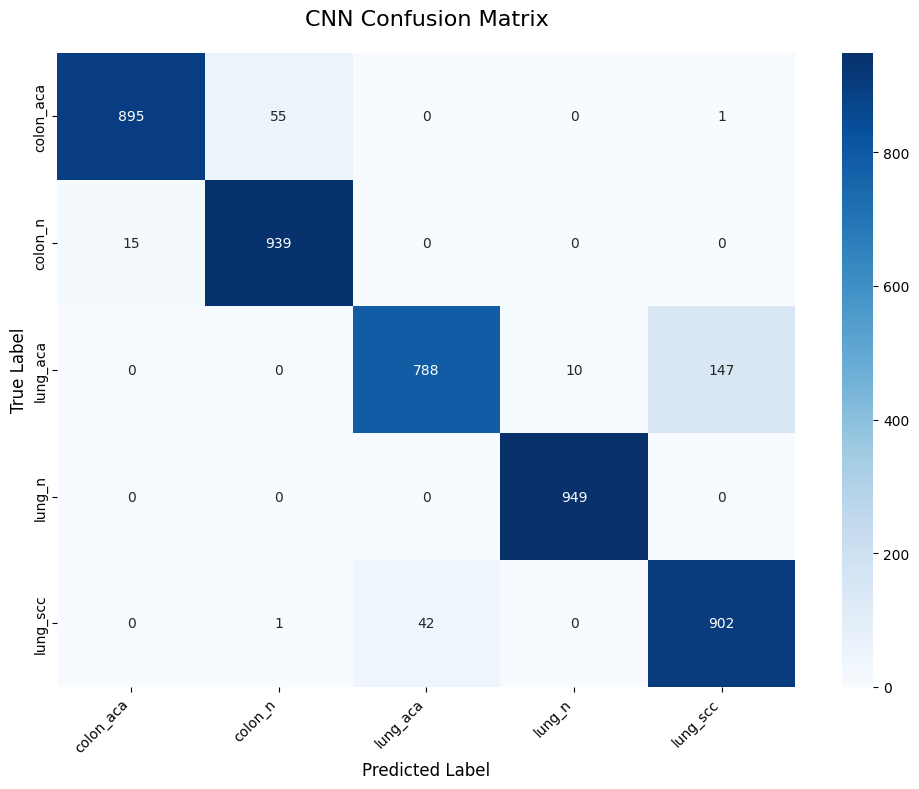


Classification Report for CNN Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.98      0.94      0.96       951
     colon_n       0.94      0.98      0.96       954
    lung_aca       0.95      0.83      0.89       945
      lung_n       0.99      1.00      0.99       949
    lung_scc       0.86      0.95      0.90       945

    accuracy                           0.94      4744
   macro avg       0.95      0.94      0.94      4744
weighted avg       0.95      0.94      0.94      4744



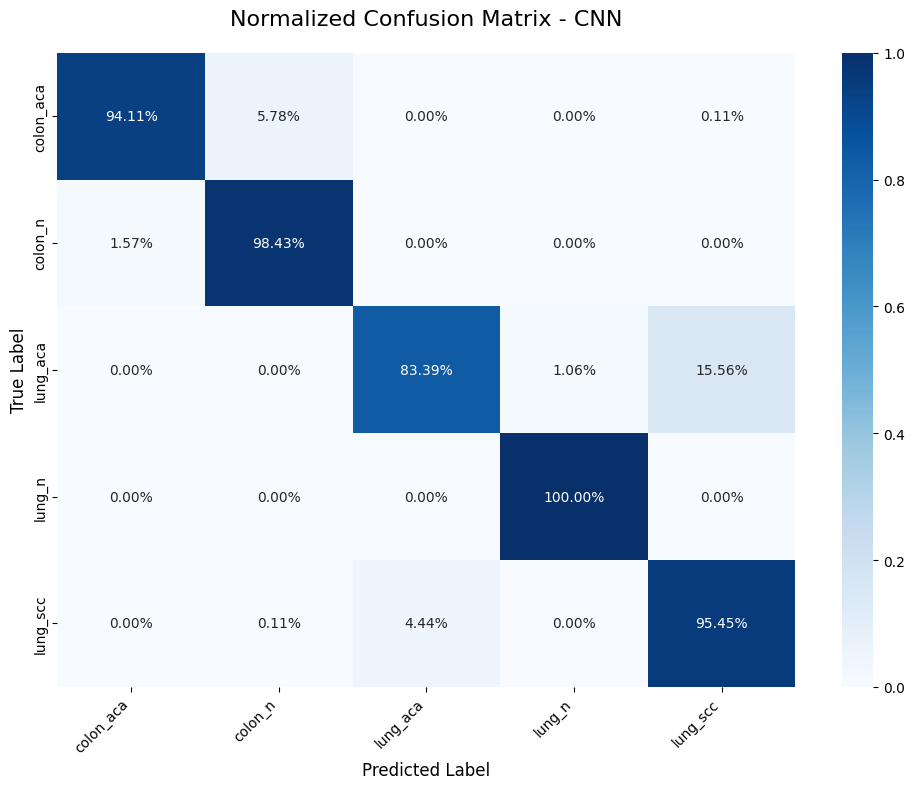


Classification Report for Normalized Confusion Matrix - CNN:
              precision    recall  f1-score   support

   colon_aca       0.98      0.94      0.96       951
     colon_n       0.94      0.98      0.96       954
    lung_aca       0.95      0.83      0.89       945
      lung_n       0.99      1.00      0.99       949
    lung_scc       0.86      0.95      0.90       945

    accuracy                           0.94      4744
   macro avg       0.95      0.94      0.94      4744
weighted avg       0.95      0.94      0.94      4744



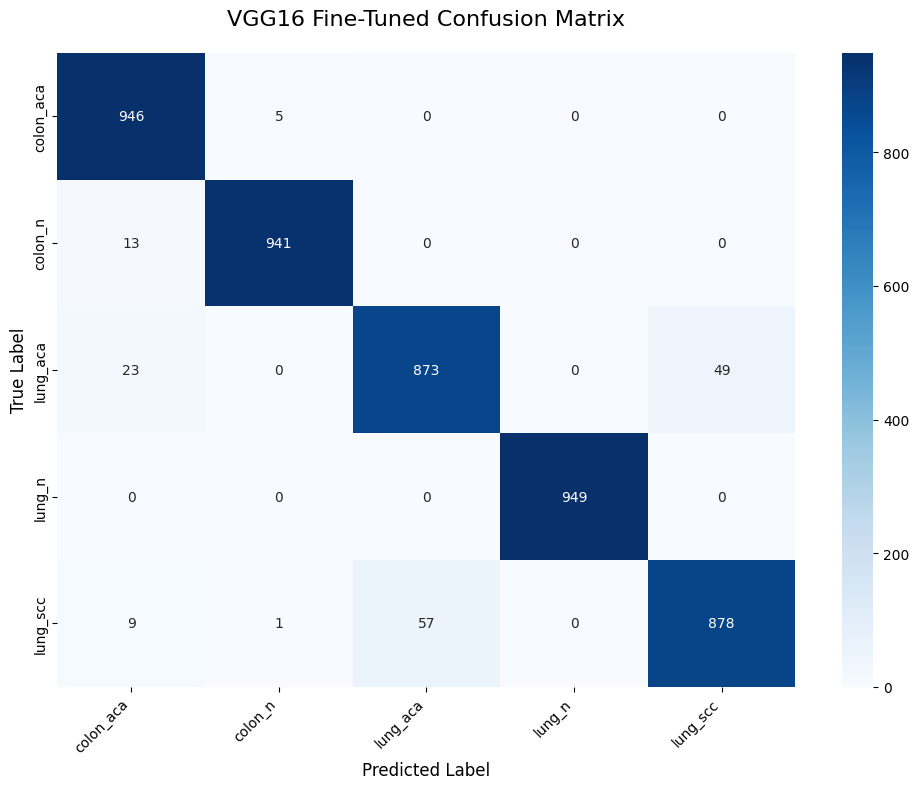


Classification Report for VGG16 Fine-Tuned Confusion Matrix:
              precision    recall  f1-score   support

   colon_aca       0.95      0.99      0.97       951
     colon_n       0.99      0.99      0.99       954
    lung_aca       0.94      0.92      0.93       945
      lung_n       1.00      1.00      1.00       949
    lung_scc       0.95      0.93      0.94       945

    accuracy                           0.97      4744
   macro avg       0.97      0.97      0.97      4744
weighted avg       0.97      0.97      0.97      4744



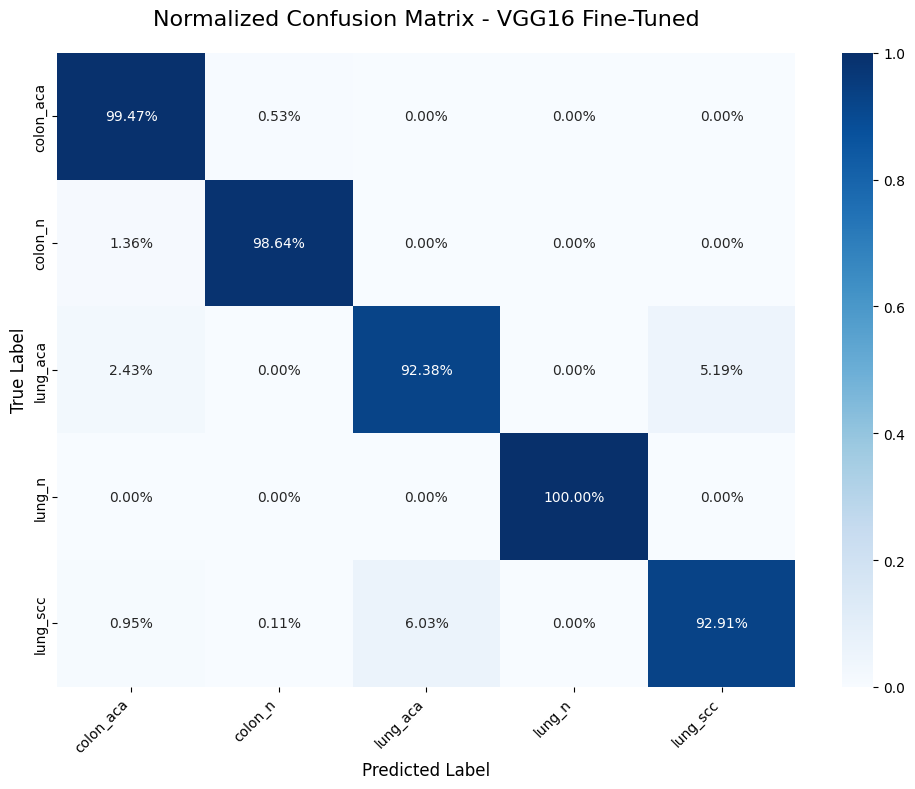


Classification Report for Normalized Confusion Matrix - VGG16 Fine-Tuned:
              precision    recall  f1-score   support

   colon_aca       0.95      0.99      0.97       951
     colon_n       0.99      0.99      0.99       954
    lung_aca       0.94      0.92      0.93       945
      lung_n       1.00      1.00      1.00       949
    lung_scc       0.95      0.93      0.94       945

    accuracy                           0.97      4744
   macro avg       0.97      0.97      0.97      4744
weighted avg       0.97      0.97      0.97      4744



NameError: name 'test_gen_resnet50' is not defined

In [ ]:
class ModelEvaluator:
    """
    A class for evaluating and visualizing machine learning model performance.
    """

    def __init__(self):
        """Initialize ModelEvaluator with default plot settings."""
        # Set default plotting parameters
        plt.rcParams['figure.figsize'] = (10, 8)
        plt.rcParams['axes.titlesize'] = 16
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10

        self.default_figsize = (10, 8)
        self.title_fontsize = 16
        self.label_fontsize = 12
        self.tick_fontsize = 10

    def plot_confusion_matrix(self, model, generator, title, normalize=False):
        """
        Plot the confusion matrix and print classification report.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            title (str): Title for the plot
            normalize (bool): Whether to normalize the confusion matrix
        """
        y_pred = model.predict(generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = generator.classes

        cm = confusion_matrix(y_true, y_pred_classes,
                            normalize='true' if normalize else None)

        plt.figure(figsize=self.default_figsize)
        fmt = '.2%' if normalize else 'd'
        sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                   xticklabels=generator.class_indices.keys(),
                   yticklabels=generator.class_indices.keys())

        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.ylabel('True Label', fontsize=self.label_fontsize)
        plt.xlabel('Predicted Label', fontsize=self.label_fontsize)
        plt.xticks(rotation=45, ha='right', fontsize=self.tick_fontsize)
        plt.yticks(fontsize=self.tick_fontsize)
        plt.tight_layout()
        plt.show()

        print(f"\nClassification Report for {title}:")
        print(classification_report(y_true, y_pred_classes,
                                 target_names=generator.class_indices.keys()))

    def plot_training_history(self, histories, titles):
        """
        Compare training histories of multiple models.

        Args:
            histories (list): List of training history dictionaries
            titles (list): List of model titles corresponding to histories
        """
        metrics = ['accuracy', 'loss']
        subplot_titles = ['Model Accuracy Comparison', 'Model Loss Comparison']
        y_labels = ['Accuracy', 'Loss']
        legend_locations = ['lower right', 'upper right']

        plt.figure(figsize=(15, 5))

        for i, (metric, subplot_title, y_label, legend_loc) in enumerate(
            zip(metrics, subplot_titles, y_labels, legend_locations), 1
        ):
            plt.subplot(1, 2, i)
            for history, title in zip(histories, titles):
                plt.plot(history[f'{metric}'], label=f'{title} Train')
                plt.plot(history[f'val_{metric}'], label=f'{title} Val')

            plt.title(subplot_title, fontsize=self.label_fontsize, pad=20)
            plt.ylabel(y_label, fontsize=self.label_fontsize)
            plt.xlabel('Epoch', fontsize=self.label_fontsize)
            plt.legend(loc=legend_loc)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_multiclass_roc(self, model, generator, n_classes, title):
        """
        Plot ROC curves for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes (int): Number of classes
            title (str): Title for the plot
        """
        y_score = model.predict(generator, verbose=0)
        y_true = label_binarize(generator.classes, classes=range(n_classes))

        fpr, tpr, roc_auc = {}, {}, {}

        # Calculate ROC curve and ROC area for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                linestyle=':', linewidth=4)

        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i],
                    label=f'Class {list(generator.class_indices.keys())[i]} '
                          f'(AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.02])
        plt.xlabel('False Positive Rate', fontsize=self.label_fontsize)
        plt.ylabel('True Positive Rate', fontsize=self.label_fontsize)
        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.legend(loc="lower right", fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    def plot_precision_recall_curve(self, model, generator, n_classes, title):
        """
        Plot Precision-Recall curve for multiclass classification.

        Args:
            model: Trained model to make predictions
            generator: Data generator for the dataset
            n_classes (int): Number of classes
            title (str): Title for the plot
        """
        y_score = model.predict(generator, verbose=0)
        y_true = label_binarize(generator.classes, classes=range(n_classes))

        precision, recall, avg_precision = {}, {}, {}

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(
                y_true[:, i], y_score[:, i]
            )
            avg_precision[i] = average_precision_score(
                y_true[:, i], y_score[:, i]
            )

        # Compute micro-average precision-recall curve
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_true.ravel(), y_score.ravel()
        )
        avg_precision["micro"] = average_precision_score(
            y_true, y_score, average="micro"
        )

        plt.figure(figsize=(8, 6))
        plt.step(recall['micro'], precision['micro'], where='post',
                label=f'Micro-average PR (AP = {avg_precision["micro"]:.2f})')

        for i in range(n_classes):
            plt.step(recall[i], precision[i], where='post',
                    label=f'Class {list(generator.class_indices.keys())[i]} '
                          f'(AP = {avg_precision[i]:.2f})')

        plt.xlabel('Recall', fontsize=self.label_fontsize)
        plt.ylabel('Precision', fontsize=self.label_fontsize)
        plt.title(title, fontsize=self.title_fontsize, pad=20)
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

def main():
    # Example usage
    evaluator = ModelEvaluator()

    # Evaluate CNN model
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn, 'CNN Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn,
                                  'Normalized Confusion Matrix - CNN',
                                  normalize=True)

    # Evaluate VGG16 model
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                  'VGG16 Fine-Tuned Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                  'Normalized Confusion Matrix - VGG16 Fine-Tuned',
                                  normalize=True)

    # Compare training histories
    histories = [loaded_cnn_history, loaded_vgg16_history, loaded_vgg16_ft_history]
    titles = ['CNN', 'VGG16', 'VGG16 Fine-Tuned']
    evaluator.plot_training_history(histories, titles)

    # Plot ROC and Precision-Recall curves
    n_classes = len(test_gen_cnn.class_indices)
    evaluator.plot_multiclass_roc(loaded_cnn, test_gen_cnn, n_classes,
                                'CNN ROC Curve')
    evaluator.plot_multiclass_roc(loaded_vgg16, test_gen_vgg16, n_classes,
                                'VGG16 Fine-Tuned ROC Curve')

    evaluator.plot_precision_recall_curve(loaded_cnn, test_gen_cnn, n_classes,
                                        'CNN Precision-Recall Curve')
    evaluator.plot_precision_recall_curve(loaded_vgg16, test_gen_vgg16, n_classes,
                                        'VGG16 Fine-Tuned Precision-Recall Curve')

def main():
    evaluator = ModelEvaluator()

    # Evaluate CNN model
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn, 'CNN Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_cnn, test_gen_cnn,
                                    'Normalized Confusion Matrix - CNN',
                                    normalize=True)

    # Evaluate VGG16 model
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                    'VGG16 Fine-Tuned Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_vgg16, test_gen_vgg16,
                                    'Normalized Confusion Matrix - VGG16 Fine-Tuned',
                                    normalize=True)

    # **Evaluate ResNet50 model**
    evaluator.plot_confusion_matrix(loaded_resnet50, test_gen_resnet50,
                                    'ResNet50 Confusion Matrix')
    evaluator.plot_confusion_matrix(loaded_resnet50, test_gen_resnet50,
                                    'Normalized Confusion Matrix - ResNet50',
                                    normalize=True)

    # Compare training histories (if available for ResNet50)
    # Add the ResNet50 history to the list if you have it
    histories = [
        loaded_cnn_history,
        loaded_vgg16_history,
        loaded_vgg16_ft_history,
        loaded_resnet50_history  # Add this line if history is available
    ]
    titles = [
        'CNN',
        'VGG16',
        'VGG16 Fine-Tuned',
        'ResNet50'  # Add corresponding title
    ]
    evaluator.plot_training_history(histories, titles)

    # Plot ROC and Precision-Recall curves
    n_classes = len(test_gen_cnn.class_indices)
    evaluator.plot_multiclass_roc(loaded_cnn, test_gen_cnn, n_classes, 'CNN ROC Curve')
    evaluator.plot_multiclass_roc(loaded_vgg16, test_gen_vgg16, n_classes, 'VGG16 Fine-Tuned ROC Curve')
    evaluator.plot_multiclass_roc(loaded_resnet50, test_gen_resnet50, n_classes, 'ResNet50 ROC Curve')

    evaluator.plot_precision_recall_curve(loaded_cnn, test_gen_cnn, n_classes, 'CNN Precision-Recall Curve')
    evaluator.plot_precision_recall_curve(loaded_vgg16, test_gen_vgg16, n_classes, 'VGG16 Fine-Tuned Precision-Recall Curve')
    evaluator.plot_precision_recall_curve(loaded_resnet50, test_gen_resnet50, n_classes, 'ResNet50 Precision-Recall Curve')

if __name__ == "__main__":
    main()

# Model validation: Trying to figure out why the model seems to have trained too well too quickly. (needs work)

Potential causes:
* Data Leakage
* Clever Hans Effect
* Encoding non-training sets?
* Testing on Non-Independent Data
* Data Preprocessing Artifacts:
 * Normalization applied inconsistently between training and testing.
 * Using preprocessed features that include target information.

Check for overlap between splits

In [ ]:
# Check if filenames are unique in each split
if not train_df['filename'].is_unique:
    print("Duplicate filenames in train")
if not val_df['filename'].is_unique:
    print("duplicate filenames in val")
if not test_df['filename'].is_unique:
    print("duplicate filenames in test")

# Check for overlap between splits
if not set(train_df['filename']).isdisjoint(set(val_df['filename'])):
    print("Train & Val overlap")
if not set(train_df['filename']).isdisjoint(set(test_df['filename'])):
    print("Train & Test overlap")
if not set(val_df['filename']).isdisjoint(set(test_df['filename'])):
    print("Val & Test overlap")

Image Similarity Analysis

In [ ]:
def get_image_arrays(paths, batch_size=100):
    """Vectorized conversion of images to arrays with batching."""
    all_arrays = []
    for i in range(0, len(paths), batch_size):
        batch_paths = paths[i:i + batch_size]
        batch_arrays = []
        for path in batch_paths:
            img = Image.open(path)
            img = img.resize((224, 224))
            batch_arrays.append(np.array(img).flatten())
        all_arrays.extend(batch_arrays)
    return np.array(all_arrays)

def compute_pairwise_similarities(arrays1, arrays2=None, batch_size=1000):
    """Compute pairwise similarities with batching for memory efficiency."""
    if arrays2 is None:
        arrays2 = arrays1
    n1, n2 = len(arrays1), len(arrays2)
    similarities = np.zeros((n1, n2))
    for i in range(0, n1, batch_size):
        batch1 = arrays1[i:i + batch_size]
        for j in range(0, n2, batch_size):
            batch2 = arrays2[j:j + batch_size]
            batch_similarities = cosine_similarity(batch1, batch2)
            similarities[i:i + len(batch1), j:j + len(batch2)] = batch_similarities
    return similarities

def extract_number(filename):
    """Extract numerical suffix from filename."""
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def analyze_dataset_structure(df):
    """Analyze basic dataset statistics."""
    stats = {
        'total_images (in training set)': len(df),
        'class_distribution': df['label'].value_counts().to_dict(),
        'class_percentages': df['label'].value_counts(normalize=True).to_dict(),
        'duplicate_filenames': df['filename'].duplicated().sum(),
        'unique_directories': len(set(df['filename'].apply(os.path.dirname)))
    }
    return stats

def analyze_visual_similarities(df, sample_size=100):
    """Analyze visual similarities within dataset."""
    results = []

    for class_name in df['label'].unique():
        class_files = df[df['label'] == class_name]
        if len(class_files) > sample_size:
            class_files = class_files.sample(sample_size)

        files = class_files['filename'].tolist()
        numbers = [extract_number(f) for f in files]
        valid_indices = [i for i, n in enumerate(numbers) if n is not None]

        if not valid_indices:
            continue

        files = [files[i] for i in valid_indices]
        numbers = np.array([numbers[i] for i in valid_indices])

        image_arrays = get_image_arrays(files)
        similarities_matrix = compute_pairwise_similarities(image_arrays)

        i_upper, j_upper = np.triu_indices(len(files), k=1)
        similarities = similarities_matrix[i_upper, j_upper]
        number_diffs = np.abs(numbers[i_upper] - numbers[j_upper])

        if len(similarities) > 0:
            correlation, p_value = stats.pearsonr(number_diffs, similarities)

            results.append({
                'class': class_name,
                'correlation': correlation,
                'p_value': p_value,
                'n_comparisons': len(similarities),
                'mean_similarity': np.mean(similarities),
                'std_similarity': np.std(similarities),
                'mean_number_diff': np.mean(number_diffs),
                'std_number_diff': np.std(number_diffs)
            })

    return pd.DataFrame(results)

def analyze_cross_dataset_similarities(source_df, target_df, sample_size=100):
    """Analyze similarities between two datasets."""
    source_sample = source_df.sample(min(len(source_df), sample_size))
    target_sample = target_df.sample(min(len(target_df), sample_size))

    source_arrays = get_image_arrays(source_sample['filename'].tolist())
    target_arrays = get_image_arrays(target_sample['filename'].tolist())
    similarities_matrix = compute_pairwise_similarities(source_arrays, target_arrays)

    similarities = []
    for i, (_, source_row) in enumerate(source_sample.iterrows()):
        for j, (_, target_row) in enumerate(target_sample.iterrows()):
            similarities.append({
                'similarity': similarities_matrix[i, j],
                'same_class': source_row['label'] == target_row['label'],
                'source_class': source_row['label'],
                'target_class': target_row['label']
            })

    similarities_df = pd.DataFrame(similarities)
    same_class = similarities_df[similarities_df['same_class']]['similarity']
    diff_class = similarities_df[~similarities_df['same_class']]['similarity']

    stats_dict = {
        'n_comparisons': len(similarities),
        'mean_similarity': similarities_df['similarity'].mean(),
        'std_similarity': similarities_df['similarity'].std(),
        'median_similarity': similarities_df['similarity'].median(),
        'min_similarity': similarities_df['similarity'].min(),
        'max_similarity': similarities_df['similarity'].max(),
        'same_class_stats': {
            'mean': same_class.mean(),
            'std': same_class.std(),
            'count': len(same_class)
        },
        'diff_class_stats': {
            'mean': diff_class.mean(),
            'std': diff_class.std(),
            'count': len(diff_class)
        }
    }

    if len(same_class) > 0 and len(diff_class) > 0:
        t_stat, p_value = stats.ttest_ind(same_class, diff_class)
        stats_dict.update({
            't_statistic': t_stat,
            'p_value': p_value
        })

    return stats_dict

def print_statistical_report(results):
    """Print statistical analysis results."""
    print("\nDATASET STATISTICAL ANALYSIS")
    print("="*50)

    # Dataset Structure
    structure = results['structure']
    print("\n1. Dataset Composition")
    print(f"Total Images: {structure['total_images']}")
    print("\nClass Distribution:")
    for class_name, count in structure['class_distribution'].items():
        percentage = structure['class_percentages'][class_name] * 100
        print(f"  {class_name}: {count} images ({percentage:.1f}%)")
    print(f"\nUnique Directories: {structure['unique_directories']}")
    print(f"Duplicate Filenames: {structure['duplicate_filenames']}")

    # Visual Similarities
    print("\n2. Visual Similarity Analysis")
    if not results['visual_similarities'].empty:
        print("\nCorrelation Statistics by Class:")
        print(results['visual_similarities'].round(4).to_string(index=False))

    # Cross-Dataset Analysis
    if 'cross_dataset' in results:
        print("\n3. Cross-Dataset Statistics")
        cross_stats = results['cross_dataset']
        print(f"\nComparisons: {cross_stats['n_comparisons']}")
        print(f"\nOverall Similarity Statistics:")
        print(f"  Mean: {cross_stats['mean_similarity']:.4f}")
        print(f"  Std Dev: {cross_stats['std_similarity']:.4f}")
        print(f"  Median: {cross_stats['median_similarity']:.4f}")
        print(f"  Range: [{cross_stats['min_similarity']:.4f}, {cross_stats['max_similarity']:.4f}]")

        if 't_statistic' in cross_stats:
            print(f"\nSame vs Different Class Statistics:")
            print("  Same Class:")
            print(f"    Mean: {cross_stats['same_class_stats']['mean']:.4f}")
            print(f"    Std Dev: {cross_stats['same_class_stats']['std']:.4f}")
            print("  Different Class:")
            print(f"    Mean: {cross_stats['diff_class_stats']['mean']:.4f}")
            print(f"    Std Dev: {cross_stats['diff_class_stats']['std']:.4f}")
            print(f"\nT-test Results:")
            print(f"  T-statistic: {cross_stats['t_statistic']:.4f}")
            print(f"  P-value: {cross_stats['p_value']:.4e}")

def analyze_ml_dataset(df, source_df=None, target_df=None, sample_size=100):
    """Main function to analyze ML dataset statistics."""
    results = {
        'structure': analyze_dataset_structure(df),
        'visual_similarities': analyze_visual_similarities(df, sample_size)
    }

    if source_df is not None and target_df is not None:
        results['cross_dataset'] = analyze_cross_dataset_similarities(
            source_df, target_df, sample_size=sample_size
        )

    return results

if __name__ == "__main__":
    # Example usage
    results = analyze_ml_dataset(
        df=train_df,
        source_df=test_df,
        target_df=train_df,
        sample_size=500
    )
    print_statistical_report(results)


DATASET STATISTICAL ANALYSIS

1. Dataset Composition
Total Images: 14232

Class Distribution:
  colon_n: 2864 images (20.1%)
  colon_aca: 2852 images (20.0%)
  lung_n: 2846 images (20.0%)
  lung_aca: 2836 images (19.9%)
  lung_scc: 2834 images (19.9%)

Unique Directories: 5
Duplicate Filenames: 0

2. Visual Similarity Analysis

Correlation Statistics by Class:
    class  correlation  p_value  n_comparisons  mean_similarity  std_similarity  mean_number_diff  std_number_diff
  colon_n       0.0163   0.0000         124750           0.9682          0.0042         1661.0639        1173.9878
 lung_scc       0.0043   0.1322         124750           0.9684          0.0105         1636.4817        1157.6493
   lung_n      -0.0346   0.0000         124750           0.9598          0.0063         1700.9330        1202.9101
colon_aca      -0.0338   0.0000         124750           0.9719          0.0058         1671.9564        1182.2531
 lung_aca       0.0219   0.0000         124750           0.95

Conclusions:
1. Not sure what to make of the level of similarity yet. Maybe need to compare to other datasets...
2. Not much Filename Number Correlations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.9 MB/s eta 0:00:00


100%|██████████| 4750/4750 [00:45<00:00, 105.19it/s]


Number of duplicate images found: 115
List of duplicate images:
                                                filename      label  \
8830   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
7940   data/lung_colon_image_set/lung_image_sets/lung...   lung_aca   
24396  data/lung_colon_image_set/colon_image_sets/col...  colon_aca   
846    data/lung_colon_image_set/lung_image_sets/lung...     lung_n   
19217  data/lung_colon_image_set/colon_image_sets/col...    colon_n   

             image_hash  
8830   cae72e8b285b12cd  
7940   a76d53b26c11a647  
24396  e1b93ae6068b3f84  
846    953e79e009cf5cd0  
19217  eb72258f1a7c4853  


100%|██████████| 4692/4692 [00:14<00:00, 315.27it/s] 

Number of near-duplicate pairs found: 65

Duplicate group with hash 81864f677923b91b:


,filename,label
8365,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
7220,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash 8299f9f0cc81ceec:


,filename,label
7190,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8451,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash 894b22cb1efede04:


,filename,label
24669,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
22530,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash 89f1aa8af0d55dc4:


,filename,label
13779,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
11193,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash 8bab91d64db4c613:


,filename,label
19381,data/lung_colon_image_set/colon_image_sets/col...,colon_n
19319,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash 8bf95ac296059fa2:


,filename,label
429,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
3281,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash 8fdf30e33e61201e:


,filename,label
6543,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
7343,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash 91915dca246f8b2f:


,filename,label
3198,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
2507,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash 929cd1a79e698786:


,filename,label
3278,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
2228,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash 93a1961d5d5f8863:


,filename,label
3668,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
623,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash 953e79e009cf5cd0:


,filename,label
846,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
3374,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash 95c54cba59f28b16:


,filename,label
23786,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
21475,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash 9a53daa67b473340:


,filename,label
5347,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8546,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash 9c71f1e092c15f4e:


,filename,label
11751,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
10497,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash 9cbca585f5e9a111:


,filename,label
24847,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
20432,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash 9ccb7fe5680c889a:


,filename,label
18633,data/lung_colon_image_set/colon_image_sets/col...,colon_n
15947,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash 9de45043942eab5f:


,filename,label
12647,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
10537,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash a76d53b26c11a647:


,filename,label
7940,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8999,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash a959bc8442b2c5f7:


,filename,label
16142,data/lung_colon_image_set/colon_image_sets/col...,colon_n
18014,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash ab6bda64c9a52499:


,filename,label
7160,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
5829,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash abad47121fc5ca0d:


,filename,label
634,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
4236,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash ad1323e60d1bf274:


,filename,label
23112,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24264,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash aff43584ed3950c2:


,filename,label
1526,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
349,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash b128d5d6b7291e61:


,filename,label
7057,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
6662,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash b4136b83ebf41d24:


,filename,label
15655,data/lung_colon_image_set/colon_image_sets/col...,colon_n
19194,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash b4af6ae87954c306:


,filename,label
3093,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
73,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash b59bb66b74647084:


,filename,label
22337,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24144,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash b858b68f9b829bb0:


,filename,label
22144,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
22965,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
21868,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash bccc1010f867d7f4:


,filename,label
3196,data/lung_colon_image_set/lung_image_sets/lung...,lung_n
1302,data/lung_colon_image_set/lung_image_sets/lung...,lung_n



Duplicate group with hash be6ad2eda19013d8:


,filename,label
7519,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8859,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash c23de896edd848c3:


,filename,label
16832,data/lung_colon_image_set/colon_image_sets/col...,colon_n
19291,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash c55779a25f47c904:


,filename,label
11210,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
13670,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash c7b2329a964a6d4b:


,filename,label
19561,data/lung_colon_image_set/colon_image_sets/col...,colon_n
19707,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash ca96baa98493276e:


,filename,label
24151,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
21710,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash cae72e8b285b12cd:


,filename,label
8830,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
5211,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash cb185ce9425d07fc:


,filename,label
14097,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
10843,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash cd639c2e352c33d4:


,filename,label
22590,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
23209,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash ce62bac9e4d7403a:


,filename,label
18461,data/lung_colon_image_set/colon_image_sets/col...,colon_n
17022,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash d02237e70a3d6f46:


,filename,label
24534,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24950,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash d2548efa981bb585:


,filename,label
13623,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
11681,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Duplicate group with hash d31564ee11eb6a4a:


,filename,label
17324,data/lung_colon_image_set/colon_image_sets/col...,colon_n
18924,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash d43c16f63b9e8942:


,filename,label
22299,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24297,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash d475d5a5b6c69051:


,filename,label
6296,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8744,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash d76f4a166088b16f:


,filename,label
20534,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24268,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash dad92d2d95651436:


,filename,label
17884,data/lung_colon_image_set/colon_image_sets/col...,colon_n
18809,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash e1b93ae6068b3f84:


,filename,label
24396,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
21182,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash e80b95653f9f0332:


,filename,label
5999,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
6295,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash e847b228dc569d3c:


,filename,label
6416,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca
8567,data/lung_colon_image_set/lung_image_sets/lung...,lung_aca



Duplicate group with hash ea94a11bebdc40f1:


,filename,label
21839,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
21812,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash eb72258f1a7c4853:


,filename,label
19217,data/lung_colon_image_set/colon_image_sets/col...,colon_n
15663,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash ec065785d7276329:


,filename,label
15415,data/lung_colon_image_set/colon_image_sets/col...,colon_n
15493,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash ec0e328c66b355d3:


,filename,label
20472,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24306,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash ee93b103b026e86f:


,filename,label
20792,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
24645,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash f121deb4427dd2d0:


,filename,label
16309,data/lung_colon_image_set/colon_image_sets/col...,colon_n
17812,data/lung_colon_image_set/colon_image_sets/col...,colon_n



Duplicate group with hash f15e071c8fb28363:


,filename,label
24434,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
20605,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash f28cb5865393ab51:


,filename,label
21837,data/lung_colon_image_set/colon_image_sets/col...,colon_aca
22740,data/lung_colon_image_set/colon_image_sets/col...,colon_aca



Duplicate group with hash fdc05a2270d2d976:


,filename,label
11000,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc
10480,data/lung_colon_image_set/lung_image_sets/lung...,lung_scc



Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca326.jpeg
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1212.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4626.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2656.jpeg
Images in group 2:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca431.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4532.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca4585.jpeg

Hamming Distance: 4
Images in group 1:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca1293.jpeg
Images in group 2:
 - data/lung_colon_image_set/colon_image_sets/colon_aca/colonca699.jpeg

Hamming Distance: 2
Images in group 1:
 - data/lung_colon_image_set/lung_image_sets/lung_aca/lungaca4344.jpeg
Ima

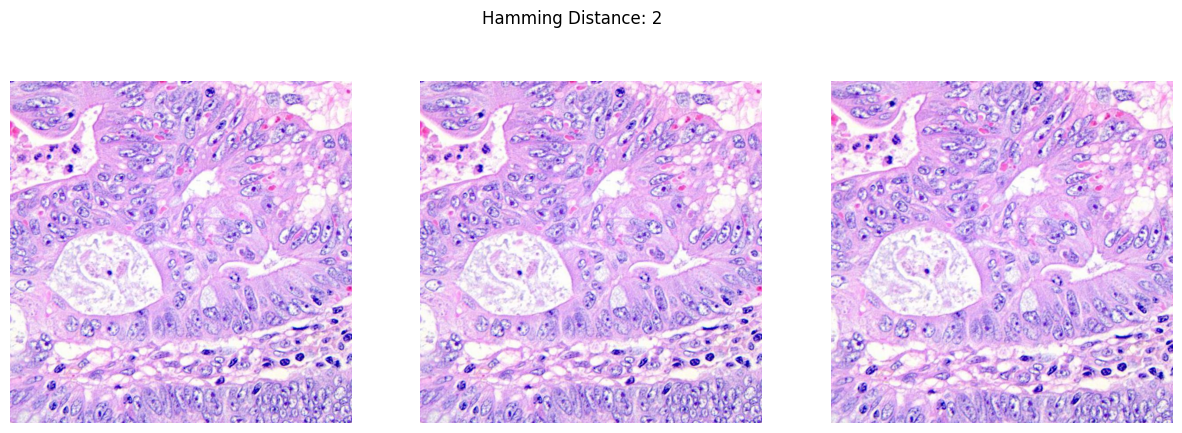

In [ ]:
!pip install imagehash Pillow tqdm

import imagehash
from PIL import Image
from tqdm import tqdm



# Compute Image Hashes

# Initialize an empty dictionary to store hashes
hashes = {}

# Iterate over all images and compute hashes
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Open the image file
        image = Image.open(row['filename'])
        # Compute the perceptual hash
        image_hash = imagehash.phash(image)
        # Store the hash as a string
        hashes[row['filename']] = str(image_hash)
    except Exception as e:
        # Handle images that can't be opened
        hashes[row['filename']] = None

# Add the hashes to the DataFrame
df['image_hash'] = df['filename'].map(hashes)


# Identify Duplicates

# Find Exact Duplicates

# Count the number of occurrences of each hash
hash_counts = df['image_hash'].value_counts()

# Identify hashes that occur more than once
duplicate_hashes = hash_counts[hash_counts > 1].index

# Filter the DataFrame to show only duplicate images
duplicates_df = df[df['image_hash'].isin(duplicate_hashes)].copy()

print(f"Number of duplicate images found: {len(duplicates_df)}")
print("List of duplicate images:")
print(duplicates_df[['filename', 'label', 'image_hash']].head())



# Find Near-Duplicates

from itertools import combinations
from collections import defaultdict

# Create a mapping from image hashes to filenames
hash_to_filenames = defaultdict(list)
for idx, row in df.iterrows():
    hash_to_filenames[row['image_hash']].append(row['filename'])

# Convert hash strings to integers for computation
hash_to_int = {h: int(h, 16) for h in hash_to_filenames if h is not None}

# Set a Hamming distance threshold
threshold = 5  # Adjust this value based on desired sensitivity

# Find near-duplicates
near_duplicates = []

# Generate combinations of hashes
hash_list = list(hash_to_int.keys())
for i in tqdm(range(len(hash_list))):
    hash1 = hash_to_int[hash_list[i]]
    filenames1 = hash_to_filenames[hash_list[i]]
    for j in range(i + 1, len(hash_list)):
        hash2 = hash_to_int[hash_list[j]]
        filenames2 = hash_to_filenames[hash_list[j]]
        # Compute Hamming distance
        hamming_dist = bin(hash1 ^ hash2).count('1')
        if hamming_dist <= threshold:
            near_duplicates.append({
                'hash1': hash_list[i],
                'hash2': hash_list[j],
                'filenames1': filenames1,
                'filenames2': filenames2,
                'hamming_distance': hamming_dist
            })

print(f"Number of near-duplicate pairs found: {len(near_duplicates)}")



# Analyze Results

# View Exact Duplicates

# Group duplicates by image_hash
duplicate_groups = duplicates_df.groupby('image_hash')

# Display duplicates
for image_hash, group in duplicate_groups:
    print(f"\nDuplicate group with hash {image_hash}:")
    display(group[['filename', 'label']])


# View Near-Duplicates

# Display near-duplicate pairs
for nd in near_duplicates[:5]:  # Show first 5 for brevity
    print(f"\nHamming Distance: {nd['hamming_distance']}")
    print("Images in group 1:")
    for fname in nd['filenames1']:
        print(f" - {fname}")
    print("Images in group 2:")
    for fname in nd['filenames2']:
        print(f" - {fname}")



# Visualization
import matplotlib.pyplot as plt

def display_images(image_paths, title):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    fig.suptitle(title)
    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display images for the first near-duplicate pair
if near_duplicates:
    nd = near_duplicates[0]
    display_images(nd['filenames1'] + nd['filenames2'], f"Hamming Distance: {nd['hamming_distance']}")

Checking for Patches (I believe I did this before do the previous check for "Filename Number Correlations". Based on the results of that, patches might not be a thing, but I'm not 100% sure.

In [ ]:
import re

def extract_number(filename):
    # Extract the number from the filename
    match = re.search(r'(\d+)\.jpeg$', filename)
    return int(match.group(1)) if match else None

def check_sequential_patches(df, window=10):
    sequences = []
    for label in df['label'].unique():
        label_files = df[df['label'] == label]['filename']
        numbers = sorted([extract_number(f) for f in label_files])

        # Look for close sequential numbers
        for i in range(len(numbers)-1):
            if numbers[i+1] - numbers[i] <= window:
                sequences.append((label, numbers[i], numbers[i+1]))

    return sequences

# Check for nearby sequence numbers within each set
print("Checking for potentially related patches...")
print("\nIn Training set:")
train_sequences = check_sequential_patches(train_df)
print(f"Found {len(train_sequences)} potentially related pairs")
if train_sequences:
    print("First few examples:", train_sequences[:5])

# Check for nearby sequence numbers across sets
def check_cross_set_similarity(df1, df2, window=10):
    df1_numbers = [(extract_number(f), l) for f, l in zip(df1['filename'], df1['label'])]
    df2_numbers = [(extract_number(f), l) for f, l in zip(df2['filename'], df2['label'])]

    close_pairs = []
    for num1, label1 in df1_numbers:
        for num2, label2 in df2_numbers:
            if label1 == label2 and abs(num1 - num2) <= window:
                close_pairs.append((label1, num1, num2))

    return close_pairs

print("\nChecking for potentially related patches across sets...")
train_test_similar = check_cross_set_similarity(train_df, test_df)
print(f"Found {len(train_test_similar)} potentially related pairs between train and test")
if train_test_similar:
    print("First few examples:", train_test_similar[:5])

Checking for potentially related patches...

In Training set:
Found 14 potentially related pairs
First few examples: [('colon_n', 2585, 2593), ('colon_n', 3360, 3370), ('colon_n', 3633, 3639), ('colon_n', 3673, 3677), ('colon_aca', 1330, 1339)]

Checking for potentially related patches across sets...
Found 712 potentially related pairs between train and test
First few examples: [('colon_n', 555, 561), ('colon_n', 555, 552), ('colon_n', 555, 554), ('colon_n', 555, 557), ('colon_n', 555, 548)]


The 712 potentially related pairs between train and test may be the source of data leakage through related patches from the same whole slide images (WSIs) being split across training and test sets.

To fix this, I'm trying to implement a more robust train/test split that keeps all patches from the same WSI together



In [ ]:
def get_patch_group(filename):
    # Group patches by hundreds to keep related patches together
    number = extract_number(filename)
    return number // 100

def strategic_split(df, test_size=0.2, val_size=0.2):
    # Get unique patch groups
    df['patch_group'] = df['filename'].apply(get_patch_group)
    unique_groups = df['patch_group'].unique()

    # Split at the group level
    test_groups = set(np.random.choice(
        unique_groups,
        size=int(len(unique_groups) * test_size),
        replace=False
    ))

    remaining_groups = set(unique_groups) - test_groups
    val_groups = set(np.random.choice(
        list(remaining_groups),
        size=int(len(unique_groups) * val_size),
        replace=False
    ))
    train_groups = remaining_groups - val_groups

    # Split the dataframe
    train_df = df[df['patch_group'].isin(train_groups)]
    val_df = df[df['patch_group'].isin(val_groups)]
    test_df = df[df['patch_group'].isin(test_groups)]

    return train_df, val_df, test_df